# APY & Volatility

## Yearn Vaults

In [1]:
"""load yearn vaults"""
from src.yearn import Yearn, Network, Subgraph

yearn = Yearn(Network.Mainnet)
subgraph = Subgraph(Network.Mainnet)
vaults = yearn.vaults

In [2]:
"""collect share price data from the subgraph"""
import jsons
from tqdm.notebook import tqdm
import pandas as pd


data = {}
for vault in tqdm(vaults):
    # collect share prices from update events
    res = subgraph.price_per_share(vault, vault.inception)
    df = pd.DataFrame(jsons.dump(res))
    if len(df) == 0:
        continue
    df['datetime'] = pd.to_datetime(df.timestamp, unit='ms')
    df.set_index('datetime', inplace=True)
    prices = pd.to_numeric(df.pricePerShare)

    # filter out harvests
    prices = prices[prices.diff() != 0]
    prices = prices.groupby(pd.Grouper(freq='D')).last()

    # append to data
    data[vault.name] = prices

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

early stopping


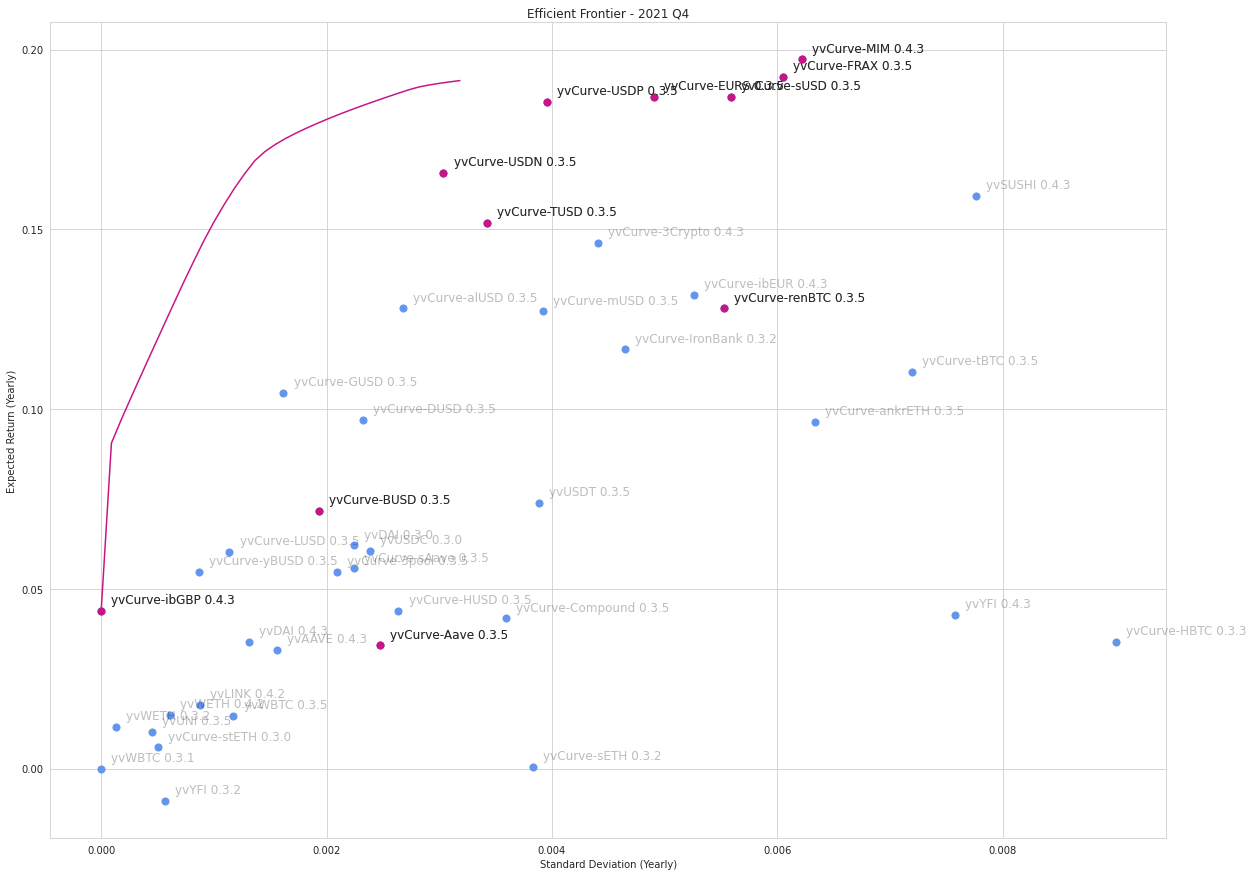

In [3]:
"""plot the efficient frontier"""
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(20, 15))
# ax.set_title("Efficient Frontier - 2022 Q1")
ax.set_title("Efficient Frontier - 2021 Q4")
ax.set_ylabel("Expected Return (Yearly)")
ax.set_xlabel("Standard Deviation (Yearly)")

# interpolated prices
df = pd.DataFrame(data)
df = df[df.columns[(~np.isnan(df)).sum() > 1]]
log_prices = np.log(df).interpolate(method='polynomial', order=1)  # linear interpolation in log prices
# prices = np.exp(log_prices)['2022-01-01':'2022-04-01'].dropna(axis=1)
prices = np.exp(log_prices)['2021-10-01':'2022-01-01'].dropna(axis=1)
returns = prices.pct_change().dropna(axis=0)

# extrapolated mean & covariance
T = 365
mu = (1 + returns).prod() ** (T / len(returns)) - 1
cov = returns.cov() * T
sigma = np.sqrt(np.diag(cov))

# remove outliers
mu_iqr = np.quantile(mu, 0.75) - np.quantile(mu, 0.25)
mu_median = np.median(mu)
mask = (mu > mu_median + 1.5 * mu_iqr) | (mu < mu_median - 1.5 * mu_iqr)

sigma_iqr = np.quantile(sigma, 0.75) - np.quantile(sigma, 0.25)
sigma_median = np.median(sigma)
mask |= (sigma > sigma_median + 1.5 * sigma_iqr) | (sigma < sigma_median - 1.5 * sigma_iqr)

mu = mu[~mask]
returns = returns[mu.index]
cov = returns.cov() * T
sigma = np.sqrt(np.diag(cov))

# plot assets
ax.scatter(sigma, mu, color='cornflowerblue', s=50)
ylim = mu.max() - mu.min()
xlim = sigma.max() - sigma.min()
for _sigma, _mu, _name in zip(sigma, mu, mu.index):
    ax.text(_sigma + xlim / 100, _mu + ylim / 100, _name, fontsize=12, alpha=0.3)


# Efficient Frontier
def efficient_return(target_std):
    N = len(mu)

    def neg_portfolio_return(weights):
        return -(mu * weights).sum()

    def portfolio_std(weights):
        return np.sqrt((weights[np.newaxis, :] @ cov @ weights[:, np.newaxis]).sum())

    constraints = (
        {'type': 'eq', 'fun': lambda x: portfolio_std(x) - target_std},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
    )
    bounds = tuple((0, 1) for _ in range(N))
    result = minimize(neg_portfolio_return, N*[1 / N], bounds=bounds, constraints=constraints)
    return -result.fun, result.x


num_samples = 100
threshold = 0.1

stds = np.linspace(sigma.min(), sigma.max(), num_samples)
mus, nonzero = [], set({})
last_mu = 0.0
for idx in tqdm(range(num_samples)):
    new_mu, weights = efficient_return(stds[idx])
    nonzero.update(set(*np.nonzero(weights > threshold)))
    if new_mu >= last_mu:
        last_mu = new_mu
        mus.append(new_mu)
    else:
        print("early stopping")
        break

ax.plot(stds[:len(mus)], mus, color='mediumvioletred')

for idx in nonzero:
    ax.scatter(sigma[idx], mu[idx], color='mediumvioletred', s=50)
    ax.text(sigma[idx] + xlim / 100, mu[idx] + ylim / 100, mu.index[idx], fontsize=12)

## DeFi Llama

In [7]:
"""load apy data from DeFi Llama"""
import pandas as pd
import numpy as np

raw = pd.read_csv('../data/defi_llama_pools_2022_05_20.csv')
raw = raw[['timestamp', 'project', 'chain', 'symbol', 'apy']]
raw['id'] = raw.project + '-' + raw.chain + '-' + raw.symbol
raw.set_index(pd.to_datetime(raw.timestamp), inplace=True)
raw.drop(columns=['timestamp'], inplace=True)
raw

,project,chain,symbol,apy,id
timestamp,,,,,
2022-03-27 20:00:00+00:00,badger-dao,Ethereum,crvRenWSBTC,0.000000,badger-dao-Ethereum-crvRenWSBTC
2022-03-27 20:00:00+00:00,badger-dao,Ethereum,crvRenWBTC,0.363403,badger-dao-Ethereum-crvRenWBTC
2022-03-27 20:00:00+00:00,badger-dao,Ethereum,tbtc/sbtcCrv,0.889738,badger-dao-Ethereum-tbtc/sbtcCrv
2022-03-27 20:00:00+00:00,badger-dao,Ethereum,crvRenWBTC,0.000000,badger-dao-Ethereum-crvRenWBTC
2022-03-27 20:00:00+00:00,badger-dao,Ethereum,UNI-V2,14.433410,badger-dao-Ethereum-UNI-V2
...,...,...,...,...,...
2022-05-20 19:00:00+00:00,geist-finance,Fantom,gfUSDT,3.259829,geist-finance-Fantom-gfUSDT
2022-05-20 19:00:00+00:00,geist-finance,Fantom,gUSDC,1.033125,geist-finance-Fantom-gUSDC
2022-05-20 19:00:00+00:00,geist-finance,Fantom,gCRV,2.411566,geist-finance-Fantom-gCRV


In [14]:
from tqdm.notebook import tqdm

data = {}
for name, group in tqdm(raw.groupby(raw.id)):
    returns = group.apy[group.apy != 0]
    returns = returns.groupby(pd.Grouper(freq='D')).mean()
    try:
        returns = returns.interpolate(method='polynomial', order=1)
    except ValueError:
        continue
    if len(returns) > 0:
        data[name] = returns

  0%|          | 0/9276 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

early stopping


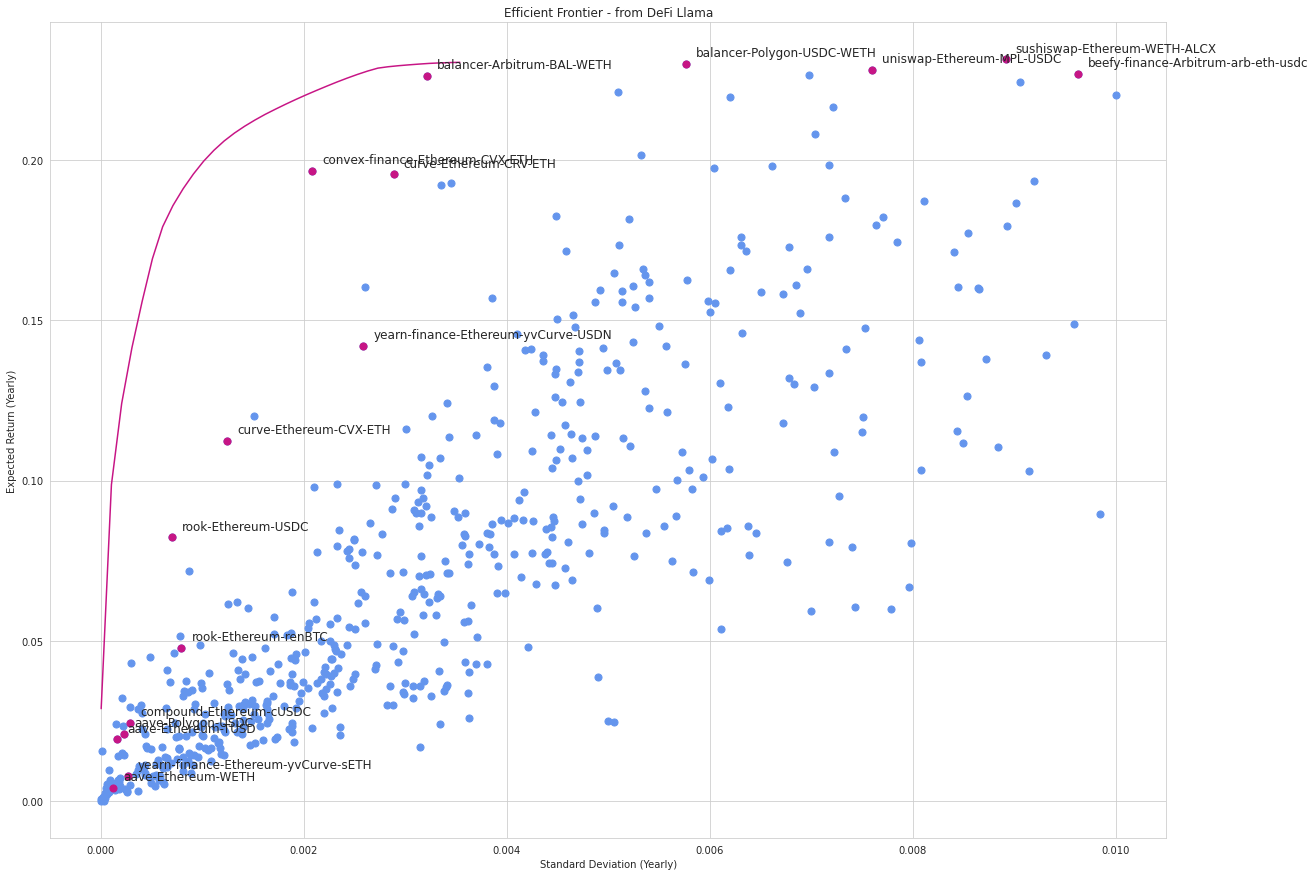

In [52]:
"""plot the efficient frontier"""
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(20, 15))
ax.set_title("Efficient Frontier - from DeFi Llama")
ax.set_ylabel("Expected Return (Yearly)")
ax.set_xlabel("Standard Deviation (Yearly)")

# interpolated returns
T = 365
returns = pd.DataFrame(data).dropna(axis=1) / 100
returns = (1 + returns) ** (1 / T) - 1

# extrapolated mean & covariance
mu = (1 + returns).prod() ** (T / len(returns)) - 1
cov = returns.cov() * T
sigma = np.sqrt(np.diag(cov))

# remove outliers
mu_iqr = np.quantile(mu, 0.75) - np.quantile(mu, 0.25)
mu_median = np.median(mu)
mask = (mu > mu_median + 1.5 * mu_iqr) | (mu < mu_median - 1.5 * mu_iqr)

sigma_iqr = np.quantile(sigma, 0.75) - np.quantile(sigma, 0.25)
sigma_median = np.median(sigma)
mask |= (sigma > sigma_median + 1.5 * sigma_iqr) | (sigma < sigma_median - 1.5 * sigma_iqr)

mu = mu[~mask]
returns = returns[mu.index]
cov = returns.cov() * T
sigma = np.sqrt(np.diag(cov))

# plot assets
ax.scatter(sigma, mu, color='cornflowerblue', s=50)
ylim = mu.max() - mu.min()
xlim = sigma.max() - sigma.min()
# for _sigma, _mu, _name in zip(sigma, mu, mu.index):
    # ax.text(_sigma + xlim / 100, _mu + ylim / 100, _name, fontsize=12, alpha=0.3)


# Efficient Frontier
def efficient_return(target_std):
    N = len(mu)

    def neg_portfolio_return(weights):
        return -(mu * weights).sum()

    def portfolio_std(weights):
        return np.sqrt((weights[np.newaxis, :] @ cov @ weights[:, np.newaxis]).sum())

    constraints = (
        {'type': 'eq', 'fun': lambda x: portfolio_std(x) - target_std},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
    )
    bounds = tuple((0, 1) for _ in range(N))
    result = minimize(neg_portfolio_return, N*[1 / N], bounds=bounds, constraints=constraints)
    return -result.fun, result.x


num_samples = 100
threshold = 0.05

stds = np.linspace(sigma.min(), sigma.max(), num_samples)
mus, nonzero = [], set({})
last_mu = 0.0
for idx in tqdm(range(num_samples)):
    new_mu, weights = efficient_return(stds[idx])
    nonzero.update(set(*np.nonzero(weights > threshold)))
    if new_mu >= last_mu:
        last_mu = new_mu
        mus.append(new_mu)
    else:
        print("early stopping")
        break

ax.plot(stds[:len(mus)], mus, color='mediumvioletred')

for idx in nonzero:
    ax.scatter(sigma[idx], mu[idx], color='mediumvioletred', s=50)
    ax.text(sigma[idx] + xlim / 100, mu[idx] + ylim / 100, mu.index[idx], fontsize=12)
